In [1]:
"""Offset and UPDRS correlaiton."""
%load_ext autoreload
%autoreload 2
from os.path import basename, join

from analysis_settings import *
from plot_settings import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scripts.config as cfg
from scripts.utils_plot import _save_fig, _add_band_annotations

from random import seed
import random
from matplotlib.mlab import psd
import scipy.signal as sig
from scripts.utils import elec_phys_signal
from scripts.fooof import FOOOF
from scripts.fooof.analysis import get_band_peak_fm

ModuleNotFoundError: No module named 'scripts.fooof'

# Make simulations as minimal and consistent as possible

- change scaling to get realistic uV^2/Hz units - divide scaling and y-limits by 15


#### Interesting side note: Total low beta power median around twice as large as periodic low beta power median (linear units)

# Params

In [31]:
# Calc Welch
sample_rate = 2400
welch_params = dict(fs=sample_rate, nperseg=sample_rate)
sns.set_style('darkgrid')

# Plot settings
kind_order = ['Relative', 'Absolute', 'Periodic']
palette_psd = ['k', 'grey']
c_rel = cfg.COLOR_DIC['normalized']
c_rel2 = cfg.COLOR_DIC['normalized2']
c_abs = cfg.COLOR_DIC['absolute']
c_abs2 = cfg.COLOR_DIC['absolute2']
c_per = cfg.COLOR_DIC['periodic']
c_per2 = cfg.COLOR_DIC['periodic2']
palette_kind = [c_rel, c_abs, c_per]
# log_power = False  # does not make sense for relative power
plot_peak_power = False


In [32]:
def normalize(psd, freqs):
    mask = ((freqs >= 5) & (freqs <= 95))
    factor = 100  # percentage
    psd_sum = psd[mask].sum()
    psds_norm = psd / psd_sum * factor  # percentage
    return psds_norm

### Simulation paramaters

In [33]:
# from matplotlib.colors import to_hex

# to_hex(cfg.COLOR_DIC['Tan'])

In [34]:
# Aperiodic params
sim_exponent = 1.5
offset = 1
aperiodic_params = dict(exponent=sim_exponent, offset=offset, nlv=1e-5)

# Periodic params
# beta_freq = 21
beta_freq = 17
beta_normal_power = 1
beta_normal_width = 2.5
beta_normal = (beta_freq, beta_normal_power, beta_normal_width)
beta_low = (beta_freq, beta_normal_power / 2.3, beta_normal_width / 1.75)

theta_freq = 7.5
theta_power = .6
theta_width = 2
theta = (theta_freq, theta_power, theta_width)

# beta_narrow_power = .253
# beta_narrow_width = .5
# beta_narrow_power = 1.180
# beta_narrow_width = 2
beta_strong = (beta_freq, beta_normal_power * .68, beta_normal_width * .68)
# beta_narrow = beta_normal
# beta_narrow = (beta_freq, beta_narrow_power, beta_narrow_width)

beta_narrow = (beta_freq, beta_normal_power * 1.7, beta_normal_width * 1.75)
# beta_strong = (beta_freq, beta_normal_power / 3, beta_normal_width / 7)

# offset_large = 1.5
# off_scaling = 0.838  # offset impacts oscillatory power nonlinearly
offset_large = 1.5
off_scaling = .5  # offset impacts oscillatory power nonlinearly
beta_large_offset = (beta_freq, beta_normal_power / 2.3 * off_scaling, beta_normal_width / 2.3)

# beta_freq_high = 29
beta_freq_low = 13
beta_freq_low2 = 18
freq_scaling = 1.097  # ap power impacts oscillatory power nonlinearly
# beta_low = (beta_freq_low, beta_normal_power, beta_normal_width)
# beta_low2 = (beta_freq_low2, beta_normal_power * freq_scaling, beta_normal_width)


# sim_exponent_small = 1.2
# off_scaling = .8  # exponent impacts oscillatory power nonlinearly
sim_exponent_small = .3
off_scaling = .6  # exponent impacts oscillatory power nonlinearly
beta_small_exponent = (beta_freq, beta_normal_power / 2.3 * off_scaling, beta_normal_width / 1.9)

### Power spectra simulations

In [35]:
beta_normal_sim_ap, beta_normal_sim = elec_phys_signal(**aperiodic_params,
                                  periodic_params=[beta_normal])
beta_theta_broad_sim = elec_phys_signal(**aperiodic_params,
                                        periodic_params=[theta, beta_normal])[1]
beta_narrow_sim = elec_phys_signal(**aperiodic_params,
                                   periodic_params=[beta_narrow])[1]
beta_strong_sim = elec_phys_signal(**aperiodic_params,
                                      periodic_params=[beta_strong])[1]
beta_large_offset_sim_ap, beta_large_offset_sim = elec_phys_signal(exponent=.8,
                                         offset=.83, nlv=1e-5,
                                         periodic_params=[beta_large_offset])
beta_small_exponent_sim_ap, beta_small_exponent_sim = elec_phys_signal(exponent=sim_exponent_small,
                                         offset=.4, nlv=1e-5,
                                         periodic_params=[beta_small_exponent])
beta_low_sim_ap, beta_low_sim = elec_phys_signal(exponent=.8,
                                                 offset=.4, nlv=1e-5,
                                periodic_params=[beta_low])
# beta_low2_sim = elec_phys_signal(**aperiodic_params,
#                                  periodic_params=[beta_low2])[1]

# Create reasonable uV^2/Hz units
scaling_factor = 50000
beta_normal_sim *= scaling_factor
beta_theta_broad_sim *= scaling_factor
beta_narrow_sim *= scaling_factor
beta_strong_sim *= scaling_factor
beta_large_offset_sim *= scaling_factor
beta_low_sim *= scaling_factor
beta_low_sim_ap *= scaling_factor
# beta_low2_sim *= scaling_factor
beta_small_exponent_sim *= scaling_factor
beta_large_offset_sim_ap *= scaling_factor
beta_small_exponent_sim_ap *= scaling_factor
beta_normal_sim_ap *= scaling_factor

# PSD
freqs, beta_normal_sim = sig.welch(beta_normal_sim, **welch_params)
freqs, beta_theta_broad_sim = sig.welch(beta_theta_broad_sim, **welch_params)
freqs, beta_narrow_sim = sig.welch(beta_narrow_sim, **welch_params)
freqs, beta_strong_sim = sig.welch(beta_strong_sim, **welch_params)
freqs, beta_large_offset_sim = sig.welch(beta_large_offset_sim, **welch_params)
freqs, beta_low_sim = sig.welch(beta_low_sim, **welch_params)
freqs, beta_low_sim_ap = sig.welch(beta_low_sim_ap, **welch_params)
# freqs, beta_low2_sim = sig.welch(beta_low2_sim, **welch_params)
freqs, beta_small_exponent_sim = sig.welch(beta_small_exponent_sim, **welch_params)
freqs, beta_large_offset_sim_ap = sig.welch(beta_large_offset_sim_ap, **welch_params)
freqs, beta_small_exponent_sim_ap = sig.welch(beta_small_exponent_sim_ap, **welch_params)
freqs, beta_normal_sim_ap = sig.welch(beta_normal_sim_ap, **welch_params)

### Fit FOOOF

In [36]:
beta_str = cfg.BAND_NAMES_GREEK['beta']
# beta_borders = cfg.BANDS['beta']
beta_borders = cfg.BANDS['beta_low']
theta_borders = cfg.BANDS['theta']

beta_low_str = cfg.BAND_NAMES_GREEK['beta_low']
beta_low_borders = cfg.BANDS['beta_low']

beta_high_str = cfg.BAND_NAMES_GREEK['beta_high']
beta_high_borders = cfg.BANDS['beta_high']

# Periodic power
fm = FOOOF(verbose=False)
fit_range = [1, 100]
fm.fit(freqs, beta_normal_sim, fit_range)
kwargs = dict(band=beta_borders, select_highest=True)
cf, beta_normal_sim_per_pwr_max, _ = get_band_peak_fm(fm, **kwargs)
if not plot_peak_power:
    beta_mask_fm = (fm.freqs >= beta_borders[0]) & (fm.freqs <= beta_borders[1])
    beta_normal_sim_per_pwr = fm._peak_fit[beta_mask_fm].mean()
    fm_per_normal = 10**fm.fooofed_spectrum_[beta_mask_fm]

# Get aperidiodic power at peak frequency
freq_idx = np.argmin(np.abs(fm.freqs - cf))
ap_pwr = fm._ap_fit[freq_idx]

fm.fit(freqs, beta_theta_broad_sim, fit_range)
cf, beta_theta_broad_sim_per_pwr_max, _ = get_band_peak_fm(fm, **kwargs)
if not plot_peak_power:
    beta_theta_broad_sim_per_pwr = fm._peak_fit[beta_mask_fm].mean()
fm.fit(freqs, beta_narrow_sim, fit_range)
cf, beta_narrow_sim_per_pwr_max, bw_narrow = get_band_peak_fm(fm, **kwargs)
if not plot_peak_power:
    beta_narrow_sim_per_pwr = fm._peak_fit[beta_mask_fm].mean()
fm.fit(freqs, beta_strong_sim, fit_range)
cf, beta_strong_sim_per_pwr_max, bw_strong = get_band_peak_fm(fm, **kwargs)
if not plot_peak_power:
    beta_strong_sim_per_pwr = fm._peak_fit[beta_mask_fm].mean()
fm.fit(freqs, beta_large_offset_sim, fit_range)
cf, beta_large_offset_per_pwr_max, _ = get_band_peak_fm(fm, **kwargs)
if not plot_peak_power:
    beta_large_offset_per_pwr = fm._peak_fit[beta_mask_fm].mean()
    # beta_large_offset_sim_per_pwr = fm._peak_fit[beta_mask_fm].mean()
    fm_per_large_offset = 10**fm.fooofed_spectrum_[beta_mask_fm]
ap_pwr_large = fm._ap_fit[freq_idx]

kwargs_high = kwargs.copy()
kwargs_high['band'] = beta_high_borders
fm.fit(freqs, beta_low_sim, fit_range)
cf, beta_low_sim_per_pwr_max, _ = get_band_peak_fm(fm, **kwargs)
if not plot_peak_power:
    beta_low_sim_per_pwr = fm._peak_fit[beta_mask_fm].mean()
    fm_per_low = 10**fm.fooofed_spectrum_[beta_mask_fm]
freq_idx = np.argmin(np.abs(fm.freqs - cf))
ap_pwr_low = fm._ap_fit[freq_idx]
# cf, beta_low_sim_per_pwr_high, _ = get_band_peak_fm(fm, **kwargs_high)
# if not plot_peak_power:
#     beta_low_sim_per_pwr_high = fm._peak_fit[beta_mask_fm].mean()
# freq_idx = np.argmin(np.abs(fm.freqs - cf))
# ap_pwr_high = fm._ap_fit[freq_idx]

# fm.fit(freqs, beta_low2_sim, fit_range)
# cf, beta_low2_sim_per_pwr_low, _ = get_band_peak_fm(fm, **kwargs)
# if not plot_peak_power:
#     beta_low2_sim_per_pwr_low = fm._peak_fit[beta_mask_fm].mean()
# freq_idx = np.argmin(np.abs(fm.freqs - cf))
# ap_pwr_low2 = fm._ap_fit[freq_idx]
# cf, beta_low2_sim_per_pwr_high, _ = get_band_peak_fm(fm, **kwargs_high)
# if not plot_peak_power:
#     beta_low2_sim_per_pwr_high = fm._peak_fit[beta_mask_fm].mean()
# freq_idx = np.argmin(np.abs(fm.freqs - cf))
# ap_pwr_high2 = fm._ap_fit[freq_idx]

fm.fit(freqs, beta_small_exponent_sim, fit_range)
cf, beta_small_exponent_sim_per_pwr_max, _ = get_band_peak_fm(fm, **kwargs)
if not plot_peak_power:
    beta_small_exponent_sim_per_pwr = fm._peak_fit[beta_mask_fm].mean()
    fm_per_small_exponent = 10**fm.fooofed_spectrum_[beta_mask_fm]
freq_idx = np.argmin(np.abs(fm.freqs - cf))
ap_pwr_small_exponent = fm._ap_fit[freq_idx]

### Shrink data

In [37]:
# Mask relevant frequency range
highpass = 2
# lowpass = 45
lowpass = 35
filt = (freqs >= highpass) & (freqs <= lowpass)

# Mask above highpass and below lowpass
freqs = freqs[filt]
beta_normal_sim = beta_normal_sim[filt]
beta_theta_broad_sim = beta_theta_broad_sim[filt]
# beta_normal_sim_norm = beta_normal_sim_norm[filt]
# beta_theta_broad_sim_norm = beta_theta_broad_sim_norm[filt]
beta_narrow_sim = beta_narrow_sim[filt]
# beta_narrow_sim_norm = beta_narrow_sim_norm[filt]
beta_strong_sim = beta_strong_sim[filt]
# beta_strong_sim_norm = beta_strong_sim_norm[filt]
beta_large_offset_sim = beta_large_offset_sim[filt]
# beta_large_offset_sim_norm = beta_large_offset_sim_norm[filt]
beta_low_sim = beta_low_sim[filt]
beta_low_sim_ap = beta_low_sim_ap[filt]
# beta_low_sim_norm = beta_low_sim_norm[filt]
# beta_low2_sim = beta_low2_sim[filt]
# beta_low2_sim_norm = beta_low2_sim_norm[filt]
beta_small_exponent_sim = beta_small_exponent_sim[filt]
beta_small_exponent_sim_ap = beta_small_exponent_sim_ap[filt]
beta_large_offset_sim_ap = beta_large_offset_sim_ap[filt]
beta_normal_sim_ap = beta_normal_sim_ap[filt]

### Normalize

In [38]:
# Normalize
beta_normal_sim_norm = normalize(beta_normal_sim, freqs)
beta_theta_broad_sim_norm = normalize(beta_theta_broad_sim, freqs)
beta_narrow_sim_norm = normalize(beta_narrow_sim, freqs)
beta_strong_sim_norm = normalize(beta_strong_sim, freqs)
beta_large_offset_sim_norm = normalize(beta_large_offset_sim, freqs)
beta_low_sim_norm = normalize(beta_low_sim, freqs)
beta_low_sim_ap_norm = normalize(beta_low_sim_ap, freqs)
# beta_low2_sim_norm = normalize(beta_low2_sim, freqs)
beta_small_exponent_sim_norm = normalize(beta_small_exponent_sim, freqs)

### Band power calculation

In [39]:
beta_mask = (freqs >= beta_borders[0]) & (freqs < beta_borders[1])
theta_mask = (freqs >= theta_borders[0]) & (freqs < theta_borders[1])
beta_low_mask = (freqs >= beta_low_borders[0]) & (freqs < beta_low_borders[1])
beta_high_mask = (freqs >= beta_high_borders[0]) & (freqs < beta_high_borders[1])

beta_mask = beta_low_mask

# Absolute power
if plot_peak_power:
    func = np.max
else:
    func = np.mean
beta_normal_sim_pwr = func(beta_normal_sim[beta_mask])
beta_theta_broad_sim_pwr = func(beta_theta_broad_sim[beta_mask])
beta_narrow_sim_pwr = func(beta_narrow_sim[beta_mask])
beta_strong_sim_pwr = func(beta_strong_sim[beta_mask])
beta_large_offset_sim_pwr = func(beta_large_offset_sim[beta_mask])
beta_small_exponent_sim_pwr = func(beta_small_exponent_sim[beta_mask])

beta_low_sim_pwr = func(beta_low_sim[beta_low_mask])
# beta_low2_sim_pwr_low = func(beta_low2_sim[beta_low_mask])
# beta_low_sim_pwr_high = func(beta_low_sim[beta_high_mask])
# beta_low2_sim_pwr_high = func(beta_low2_sim[beta_high_mask])


# Relative power
beta_normal_sim_norm_pwr = func(beta_normal_sim_norm[beta_mask])
beta_theta_broad_sim_norm_pwr = func(beta_theta_broad_sim_norm[beta_mask])
theta_broad_sim_norm_pwr = func(beta_theta_broad_sim_norm[theta_mask])
beta_narrow_sim_norm_pwr = func(beta_narrow_sim_norm[beta_mask])
beta_strong_sim_norm_pwr = func(beta_strong_sim_norm[beta_mask])
beta_large_offset_sim_norm_pwr = func(beta_large_offset_sim_norm[beta_mask])
beta_small_exponent_sim_norm_pwr = func(beta_small_exponent_sim_norm[beta_mask])

beta_low_sim_norm_pwr = func(beta_low_sim_norm[beta_low_mask])
# beta_low2_sim_norm_pwr_low = func(beta_low2_sim_norm[beta_low_mask])
# beta_low_sim_norm_pwr_high = func(beta_low_sim_norm[beta_high_mask])
# beta_low2_sim_norm_pwr_high = func(beta_low2_sim_norm[beta_high_mask])


# if log_power:
#     beta_normal_sim_pwr = np.log10(beta_normal_sim_pwr)
#     beta_normal_sim_norm_pwr = np.log10(beta_normal_sim_norm_pwr)

#     beta_theta_broad_sim_pwr = np.log10(beta_theta_broad_sim_pwr)
#     beta_theta_broad_sim_norm_pwr = np.log10(beta_theta_broad_sim_norm_pwr)

#     beta_narrow_sim_pwr = np.log10(beta_narrow_sim_pwr)
#     beta_narrow_sim_norm_pwr = np.log10(beta_narrow_sim_norm_pwr)
#     beta_strong_sim_pwr = np.log10(beta_strong_sim_pwr)
#     beta_strong_sim_norm_pwr = np.log10(beta_strong_sim_norm_pwr)

#     beta_large_offset_sim_pwr = np.log10(beta_large_offset_sim_pwr)
#     beta_large_offset_sim_norm_pwr = np.log10(beta_large_offset_sim_norm_pwr)
#     beta_small_exponent_sim_pwr = np.log10(beta_small_exponent_sim_pwr)
#     beta_small_exponent_sim_norm_pwr = np.log10(beta_small_exponent_sim_norm_pwr)

#     beta_low_sim_pwr_low = np.log10(beta_low_sim_pwr_low)
#     beta_low_sim_norm_pwr_low = np.log10(beta_low_sim_norm_pwr_low)
#     beta_low2_sim_pwr_low = np.log10(beta_low2_sim_pwr_low)
#     beta_low2_sim_norm_pwr_low = np.log10(beta_low2_sim_norm_pwr_low)
#     beta_low_sim_pwr_high = np.log10(beta_low_sim_pwr_high)
#     beta_low_sim_norm_pwr_high = np.log10(beta_low_sim_norm_pwr_high)
#     beta_low2_sim_pwr_high = np.log10(beta_low2_sim_pwr_high)
#     beta_low2_sim_norm_pwr_high = np.log10(beta_low2_sim_norm_pwr_high)
# else:
beta_normal_sim_per_pwr = 10**(beta_normal_sim_per_pwr + ap_pwr) - 10**ap_pwr
beta_theta_broad_sim_per_pwr = 10**(beta_theta_broad_sim_per_pwr + ap_pwr) - 10**ap_pwr
beta_narrow_sim_per_pwr = 10**(beta_narrow_sim_per_pwr + ap_pwr) - 10**ap_pwr
beta_strong_sim_per_pwr = 10**(beta_strong_sim_per_pwr + ap_pwr) - 10**ap_pwr
beta_large_offset_per_pwr = 10**(beta_large_offset_per_pwr + ap_pwr_large) - 10**ap_pwr_large
beta_low_sim_per_pwr = 10**(beta_low_sim_per_pwr + ap_pwr_low) - 10**ap_pwr_low
beta_low_sim_per_pwr_max = 10**(beta_low_sim_per_pwr_max + ap_pwr_low) - 10**ap_pwr_low
beta_large_offset_per_pwr_max = 10**(beta_large_offset_per_pwr_max + ap_pwr_large) - 10**ap_pwr_large
beta_normal_sim_per_pwr_max = 10**(beta_normal_sim_per_pwr_max + ap_pwr) - 10**ap_pwr
# beta_low2_sim_per_pwr_low = 10**(beta_low2_sim_per_pwr_low + ap_pwr_low2) - 10**ap_pwr_low2
# beta_low_sim_per_pwr_high = 10**(beta_low_sim_per_pwr_high + ap_pwr_high) - 10**ap_pwr_high
# beta_low2_sim_per_pwr_high = 10**(beta_low2_sim_per_pwr_high + ap_pwr_high2) - 10**ap_pwr_high2
beta_small_exponent_sim_per_pwr = 10**(beta_small_exponent_sim_per_pwr + ap_pwr_small_exponent) - 10**ap_pwr_small_exponent
beta_small_exponent_sim_per_pwr_max = 10**(beta_small_exponent_sim_per_pwr_max + ap_pwr_small_exponent) - 10**ap_pwr_small_exponent
ap_pwr = 10**ap_pwr
ap_pwr_large = 10**ap_pwr_large
ap_pwr_low = 10**ap_pwr_low
# ap_pwr_low2 = 10**ap_pwr_low2
# ap_pwr_high = 10**ap_pwr_high
# ap_pwr_high2 = 10**ap_pwr_high2
ap_pwr_small_exponent = 10**ap_pwr_small_exponent
# fm_per_normal = 10**(fm_per_normal + fm_ap_normal) - 10**fm_ap_normal

# replace nan (no peak found) with 0
beta_low_sim_per_pwr = np.nan_to_num(beta_low_sim_per_pwr)
# beta_low2_sim_per_pwr_low = np.nan_to_num(beta_low2_sim_per_pwr_low)
# beta_low_sim_per_pwr_high = np.nan_to_num(beta_low_sim_per_pwr_high)
# beta_low2_sim_per_pwr_high = np.nan_to_num(beta_low2_sim_per_pwr_high)

msg = f'Beta must be same in both conds but is {beta_narrow_sim_norm_pwr - beta_strong_sim_norm_pwr:.2f}'
assert np.allclose(beta_narrow_sim_norm_pwr, beta_strong_sim_norm_pwr, atol=0.01), msg

msg = f'Max. Beta must be same in both conds but is {beta_low_sim_per_pwr_max - beta_large_offset_per_pwr_max:.2f}'
assert np.allclose(beta_low_sim_per_pwr_max, beta_large_offset_per_pwr_max, atol=0.01), msg
msg = f'Mean Beta must be same in both conds but is {beta_low_sim_per_pwr - beta_large_offset_per_pwr:.2f}'
assert np.allclose(beta_low_sim_per_pwr, beta_large_offset_per_pwr, atol=0.01), msg

msg = f'Max Beta must be same in both conds but is {beta_low_sim_per_pwr_max - beta_small_exponent_sim_per_pwr_max:.2f}'
assert np.allclose(beta_low_sim_per_pwr_max, beta_small_exponent_sim_per_pwr_max, atol=0.01), msg
msg = f'Mena Beta must be same in both conds but is {beta_low_sim_per_pwr - beta_small_exponent_sim_per_pwr:.2f}'
assert np.allclose(beta_low_sim_per_pwr, beta_small_exponent_sim_per_pwr, atol=0.02), msg

# All simulations combined

In [40]:
# Settings
yticks_abs = [0, .3, .6]
ylim_abs = [yticks_abs[0], .7]
yticks_norm = [0, 5, 10]
ylim_norm = [yticks_norm[0], 11.68]

# xticks = [2, 13, 30]
# xticks = [2, 13, 20, 30]
xticks = XTICKS_FREQ_low
xticklabels = ['', 4, '', 13, 20, 30, 45]

arrowprops=dict(facecolor='black', shrink=.05, width=.75, headwidth=2,
                headlength=2)
bbox = dict(pad=0, facecolor="none", edgecolor="none")

# Theta increased

$\Delta \beta=$0
$\Delta \beta=$1.4


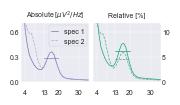

In [41]:
fig, axes = plt.subplots(1, 2, figsize=(1.75, 1), sharey=False,
                        #  width_ratios=[1, 1, 1]
                         )

# Spectra #####################################################################
ax = axes[0]
ax.plot(freqs, beta_normal_sim, c_abs, label='spec 1')
ax.plot(freqs, beta_theta_broad_sim, c_abs2, ls='--', label='spec 2')

if plot_peak_power:
    # Plot absolute peak power
    ax.plot(beta_freq, beta_normal_sim_pwr, '.', color=c_abs, markersize=1)
else:
    ax.plot(beta_borders, [beta_normal_sim_pwr, beta_normal_sim_pwr], '-', color=c_abs, markersize=1)
    ax.plot(beta_borders, [beta_theta_broad_sim_pwr, beta_theta_broad_sim_pwr], '--', color=c_abs2, markersize=1)

# Axes
ax.set_ylim(ylim_abs)
ax.set_xticks(xticks, labels=xticklabels)
# ax.set_ylabel('Absolute 'r'[$\mu V^2/Hz$]')
ax.set_title('Absolute 'r'[$\mu V^2/Hz$]', y=.95)
ax.set_label(None)
ax.set_xlim([highpass, lowpass])
# ax.legend(**leg_kwargs)
ax.legend(loc='upper right', handlelength=1, borderaxespad=0.3)
ax.set_yticks(yticks_abs)
ax.tick_params(axis='y', length=0, pad=1)

# # Annotation
# ytext = beta_normal_sim_pwr
# xtext = beta_freq
beta_abs_diff = np.abs(beta_normal_sim_pwr - beta_theta_broad_sim_pwr)
text = r'$\Delta \beta=$'f'{beta_abs_diff:.0f}'
print(text)
# ax.annotate(text, xy=(beta_freq, ytext), xytext=(xtext, ytext),
#             ha='left', va='bottom', zorder=10000, color=c_abs,
#             bbox=bbox,
#             arrowprops=arrowprops)


# Spectra Normalized ##########################################################
ax = axes[1]
ax.plot(freqs, beta_normal_sim_norm, c_rel, label='PSD 1')
ax.plot(freqs, beta_theta_broad_sim_norm, c_rel2, ls='--', label='PSD 2')

if plot_peak_power:
    # Plot absolute peak power
    ax.plot(beta_freq, beta_normal_sim_norm_pwr, '.', color=c_rel, markersize=1)
    ax.plot(beta_freq, beta_theta_broad_sim_norm_pwr, '.', color=c_rel2, markersize=1)
    ax.plot([beta_freq, beta_freq],
            [beta_normal_sim_norm_pwr, beta_theta_broad_sim_norm_pwr], '-',
            color=c_rel, markersize=1)
else:
    ax.plot(beta_borders, [beta_normal_sim_norm_pwr, beta_normal_sim_norm_pwr], '-', color=c_rel, markersize=1)
    ax.plot(beta_borders, [beta_theta_broad_sim_norm_pwr, beta_theta_broad_sim_norm_pwr], '--', color=c_rel2, markersize=1)

# Axes
ax.set_ylim(ylim_norm)
ax.set_xticks(xticks, labels=xticklabels)
# ax.set_ylabel('Relative [%]')
ax.set_title('Relative [%]', y=.96)
ax.set_label(None)
ax.set_xlim([highpass, lowpass])
# ax.legend(**leg_kwargs)
ax.set_yticks(yticks_norm)
ax.yaxis.tick_right()
ax.tick_params(axis='y', length=0, pad=1)

# Annotation
beta_rel_diff = (beta_normal_sim_norm_pwr - beta_theta_broad_sim_norm_pwr)
text = r'$\Delta \beta=$'f'{beta_rel_diff:.1f}'
print(text)


plt.tight_layout()
plt.subplots_adjust(wspace=0.05)
_save_fig(fig, join("Figure2", "sim_theta_beta"),
          SAVE_DIR, close=False, bbox_inches=None, facecolor=(1,1,1,0))

# Vary Peak width

$\Delta \beta=$0.10
$\Delta \beta=$-0.0


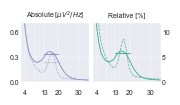

In [42]:
fig, axes = plt.subplots(1, 2, figsize=(1.75, 1), sharey=False)

# Spectra #####################################################################
ax = axes[0]
ax.plot(freqs, beta_narrow_sim, c_abs, label='spec1')
ax.plot(freqs, beta_strong_sim, c_abs2, ls='--', label='spec2')

if plot_peak_power:
    # Plot absolute peak power
    ax.plot(beta_freq, beta_strong_sim_pwr, '.', color=c_abs, markersize=1)
else:
    ax.plot(beta_borders, [beta_narrow_sim_pwr, beta_narrow_sim_pwr], '-', color=c_abs, markersize=1)
    ax.plot(beta_borders, [beta_strong_sim_pwr, beta_strong_sim_pwr], '--', color=c_abs2, markersize=1)

# Axes
ax.set_ylim(ylim_abs)
ax.set_xticks(xticks, labels=xticklabels)
# ax.set_ylabel('Absolute 'r'[$\mu V^2/Hz$]')
ax.set_title('Absolute 'r'[$\mu V^2/Hz$]', y=.95)
ax.set_label(None)
ax.set_xlim([highpass, lowpass])
# ax.legend(**leg_kwargs)
ax.set_yticks(yticks_abs)
ax.tick_params(axis='y', length=0, pad=1)

# Annotation
# ytext = beta_large_offset_sim_pwr
# xtext = beta_freq
beta_abs_diff = beta_narrow_sim_pwr - beta_strong_sim_pwr
text = r'$\Delta \beta=$'f'{beta_abs_diff:.2f}'
print(text)
# ax.annotate(text, xy=(beta_freq, ytext), xytext=(xtext, ytext),
#             ha='left', va='bottom', zorder=10000, color=c_abs,
#             bbox=bbox,
#             arrowprops=arrowprops)


# Spectra Normalized ##########################################################
ax = axes[1]
ax.plot(freqs, beta_narrow_sim_norm, c_rel, label='PSD 1')
ax.plot(freqs, beta_strong_sim_norm, c_rel2, ls='--', label='PSD 2')

if plot_peak_power:
    # Plot absolute peak power
    ax.plot(beta_freq, beta_narrow_sim_norm_pwr, '.', color=c_rel, markersize=1)
    ax.plot(beta_freq, beta_strong_sim_norm_pwr, '.', color=c_rel2, markersize=1)
    ax.plot([beta_freq, beta_freq],
            [beta_narrow_sim_norm_pwr, beta_strong_sim_norm_pwr], '-',
            color=c_rel, markersize=1)
else:
    ax.plot(beta_borders, [beta_narrow_sim_norm_pwr, beta_narrow_sim_norm_pwr], '-', color=c_rel, markersize=1)
    ax.plot(beta_borders, [beta_strong_sim_norm_pwr, beta_strong_sim_norm_pwr], '--', color=c_rel2, markersize=1)

# Axes
ylim = (0, 12.6)
ax.set_ylim(ylim_norm)
ax.set_xticks(xticks, labels=xticklabels)
# ax.set_ylabel('Relative [%]')
ax.set_title('Relative [%]', y=.96)
ax.set_label(None)
ax.set_xlim([highpass, lowpass])
# ax.legend(**leg_kwargs)
ax.set_yticks(yticks_norm)
ax.yaxis.tick_right()
ax.tick_params(axis='y', length=0, pad=1)

# Annotation
beta_rel_diff = (beta_narrow_sim_norm_pwr - beta_strong_sim_norm_pwr)
text = r'$\Delta \beta=$'f'{beta_rel_diff:.1f}'
print(text)


plt.tight_layout()
plt.subplots_adjust(wspace=0.05)
_save_fig(fig, join("Figure2", "sim_width_beta"),
          SAVE_DIR, close=False, bbox_inches=None, facecolor=(1,1,1,0))

# Elevated broadband

In [43]:
dotted_line = dict(color='dimgrey', lw=LINEWIDTH_AXES, ls=':',
                    # zorder=z_front
                    )

Absolute: $\Delta \beta=$-0.27
Periodic: $\Delta \beta=$0.00
Relative: $\Delta \beta=$1.7


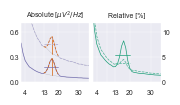

In [44]:
fig, axes = plt.subplots(1, 2, figsize=(1.75, 1), sharey=False)

# Spectra #####################################################################
ax = axes[0]
ax.plot(freqs, beta_low_sim_ap, 'k-', label=None, lw=0.05)
ax.plot(freqs, beta_low_sim, c_abs, label='spec1')
ax.plot(freqs, beta_large_offset_sim_ap, 'k-', label=None, lw=0.05)
ax.plot(freqs, beta_large_offset_sim, c_abs2, ls='--', label='spec2')

if plot_peak_power:
        # Plot absolute peak power
        ax.plot(beta_freq, beta_low_sim_pwr, '.', color=c_abs, markersize=1)
        ax.plot(beta_freq, beta_large_offset_sim_pwr, '.', color=c_abs, markersize=1)
        ax.plot([beta_freq, beta_freq],
                [beta_low_sim_pwr, beta_large_offset_sim_pwr], '-',
                color=c_abs, markersize=1)
else:
    ax.plot(beta_borders, [beta_low_sim_pwr, beta_low_sim_pwr], '-', color=c_abs, markersize=1)
    ax.plot(beta_borders, [beta_large_offset_sim_pwr, beta_large_offset_sim_pwr], '--', color=c_abs2, markersize=1)
    ax.plot(fm.freqs[beta_mask_fm], fm_per_low, '--', color=c_per)
    ax.plot(fm.freqs[beta_mask_fm], fm_per_large_offset, '--', color=c_per)
    # ax.plot(beta_borders, [fm_per_normal.mean(), fm_per_normal.mean()], '-', color=c_per, markersize=1)
    # ax.plot(fm_normal.freqs, 10**fm_normal._ap_fit, color='b', lw=LINEWIDTH_AXES)
    # ax.plot(fm_normal.freqs[beta_mask_fm], 10**fm_normal.fooofed_spectrum_[beta_mask_fm], color='r', lw=LINEWIDTH_AXES)
# Plot periodic power
if plot_peak_power:
    x_freqs = np.array([beta_freq, beta_freq])
    tot_pwr1 = ap_pwr + beta_low_sim_per_pwr
    ax.plot(x_freqs, [ap_pwr, tot_pwr1], c_per, zorder=1)
    shift = 5  # shift to left
    x_freqs_shift = x_freqs - shift
    tot_pwr2 = ap_pwr_large + beta_large_offset_per_pwr
    # ax.plot(x_freqs_shift, [ap_pwr_large, tot_pwr2], c_per, ls='--', zorder=1)
    ax.hlines(tot_pwr2, beta_freq - shift, beta_freq, **dotted_line)
    ax.hlines(ap_pwr_large, beta_freq - shift, beta_freq, **dotted_line)
else:
    # freq1 = 12.5
    freq1 = freq2 = beta_freq
    ax.plot([freq1, freq1], [ap_pwr_low, fm_per_low.max()], c_per, zorder=1)
    # freq2 = 20.5
    ax.plot([freq2, freq2], [ap_pwr_large, fm_per_large_offset[beta_borders[1] - beta_freq]], c_per, zorder=1)

    # # Plot horizontal lines
    # ax.hlines(fm_per_low.max(), freq1, beta_freq, **dotted_line)
    # ax.hlines(ap_pwr, freq1, beta_freq, **dotted_line)

    # ax.hlines(fm_per_large_offset.max(), freq2, beta_freq, **dotted_line)
    # ax.hlines(ap_pwr_large, freq2, beta_freq, **dotted_line)

# Axes
ax.set_ylim(ylim_abs)
# ax.set_ylim([0, 2.0])
ax.set_xticks(xticks, labels=xticklabels)
# ax.set_ylabel('Absolute 'r'[$\mu V^2/Hz$]')
ax.set_title('Absolute 'r'[$\mu V^2/Hz$]', y=.95)
ax.set_label(None)
ax.set_xlim([highpass, lowpass])
# ax.legend(**leg_kwargs)
ax.set_yticks(yticks_abs)
ax.tick_params(axis='y', length=0, pad=1)

# Annotation
# ytext = beta_large_offset_sim_pwr
# xtext = beta_freq
beta_abs_diff = beta_low_sim_pwr - beta_large_offset_sim_pwr
text = r'Absolute: $\Delta \beta=$'f'{beta_abs_diff:.2f}'
print(text)
# beta_per_diff = beta_low_sim_per_pwr - beta_large_offset_per_pwr
beta_per_diff = beta_low_sim_per_pwr_max - beta_large_offset_per_pwr_max
text = r'Periodic: $\Delta \beta=$'f'{beta_per_diff:.2f}'
print(text)
# ax.annotate(text, xy=(beta_freq, ytext), xytext=(xtext, ytext),
#             ha='left', va='bottom', zorder=10000, color=c_abs,
#             bbox=bbox,
#             arrowprops=arrowprops)


# Spectra Normalized ##########################################################
ax = axes[1]
ax.plot(freqs, beta_low_sim_norm, c_rel, label='PSD 1')
ax.plot(freqs, beta_large_offset_sim_norm, c_rel2, ls='--', label='PSD 2')

if plot_peak_power:
        # Plot absolute peak power
        ax.plot(beta_freq, beta_low_sim_norm_pwr, '.', color=c_rel, markersize=1)
        ax.plot(beta_freq, beta_large_offset_sim_norm_pwr, '.', color=c_rel2, markersize=1)
        ax.plot([beta_freq, beta_freq],
                [beta_low_sim_norm_pwr, beta_large_offset_sim_norm_pwr], '-',
                color=c_rel, markersize=1)
else:
    ax.plot(beta_borders, [beta_low_sim_norm_pwr, beta_low_sim_norm_pwr], '-', color=c_rel, markersize=1)
    ax.plot(beta_borders, [beta_large_offset_sim_norm_pwr, beta_large_offset_sim_norm_pwr], '--', color=c_rel2, markersize=1)

# Axes
ax.set_ylim(ylim_norm)
ax.set_xticks(xticks, labels=xticklabels)
# ax.set_ylabel('Relative [%]')
ax.set_title('Relative [%]', y=.96)
ax.set_label(None)
ax.set_xlim([highpass, lowpass])
# ax.legend(**leg_kwargs)
ax.set_yticks(yticks_norm)
ax.yaxis.tick_right()
ax.tick_params(axis='y', length=0, pad=1)

# ax.set_yscale('log')
# ax.set_xscale('log')

# Annotation
beta_rel_diff = (beta_low_sim_norm_pwr - beta_large_offset_sim_norm_pwr)
text = r'Relative: $\Delta \beta=$'f'{beta_rel_diff:.1f}'
print(text)

plt.tight_layout()
plt.subplots_adjust(wspace=0.05)
_save_fig(fig, join("Figure2", "sim_broadband_shift"),
          SAVE_DIR, close=False, bbox_inches=None, facecolor=(1,1,1,0))

# Reduce 1/f exponent

Absolute: $\Delta \beta=$-0.25
Periodic: $\Delta \beta=$-0.00
Relative: $\Delta \beta=$1.4


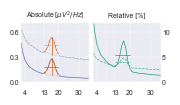

In [45]:
fig, axes = plt.subplots(1, 2, figsize=(1.75, 1), sharey=False)

# Spectra #####################################################################
ax = axes[0]
ax.plot(freqs, beta_low_sim_ap, 'k-', label=None, lw=0.05)
ax.plot(freqs, beta_low_sim, c_abs, label='spec1')
ax.plot(freqs, beta_small_exponent_sim_ap, 'k-', label=None, lw=0.05)
ax.plot(freqs, beta_small_exponent_sim, c_abs2, ls='--', label='spec2')

if plot_peak_power:
        # Plot absolute peak power
        ax.plot(beta_freq, beta_low_sim_pwr, '.', color=c_abs, markersize=1)
        ax.plot(beta_freq, beta_small_exponent_sim_pwr, '.', color=c_abs, markersize=1)
        ax.plot([beta_freq, beta_freq],
                [beta_low_sim_pwr, beta_small_exponent_sim_pwr], '-',
                color=c_abs, markersize=1)
else:
    ax.plot(beta_borders, [beta_low_sim_pwr, beta_low_sim_pwr], '-', color=c_abs, markersize=1)
    ax.plot(beta_borders, [beta_small_exponent_sim_pwr, beta_small_exponent_sim_pwr], '--', color=c_abs2, markersize=1)
    ax.plot(fm.freqs[beta_mask_fm], fm_per_low, '--', color=c_per)
    ax.plot(fm.freqs[beta_mask_fm], fm_per_small_exponent, '--', color=c_per)

# Plot periodic power
if plot_peak_power:
    x_freqs = np.array([beta_freq, beta_freq])
    tot_pwr1 = ap_pwr + beta_low_sim_per_pwr
    ax.plot(x_freqs, [ap_pwr, tot_pwr1], c_per, zorder=1)
    shift = 5  # shift to left
    x_freqs -= shift
    tot_pwr2 = ap_pwr_small_exponent + beta_small_exponent_sim_per_pwr
    ax.plot(x_freqs_shift, [ap_pwr_small_exponent, tot_pwr2], c_per, ls='--', zorder=1)
    ax.hlines(tot_pwr2, beta_freq - shift, beta_freq, **dotted_line)
    ax.hlines(ap_pwr_small_exponent, beta_freq - shift, beta_freq, **dotted_line)
else:
    ax.plot([beta_freq, beta_freq], [ap_pwr_low, fm_per_low.max()], c_per, zorder=1)
    ax.plot([beta_freq, beta_freq], [ap_pwr_small_exponent, fm_per_small_exponent.max()], c_per, zorder=1)

    # # Plot horizontal lines
    # ax.hlines(fm_per_normal.max(), beta_freq, beta_freq, **dotted_line)
    # ax.hlines(ap_pwr, beta_freq, beta_freq, **dotted_line)

    # ax.hlines(fm_per_small_exponent.max(), beta_freq, beta_freq, **dotted_line)
    # ax.hlines(ap_pwr_large, beta_freq, beta_freq, **dotted_line)
# Axes
ax.set_ylim(ylim_abs)
ax.set_xticks(xticks, labels=xticklabels)
# ax.set_ylabel('Absolute 'r'[$\mu V^2/Hz$]')
ax.set_title('Absolute 'r'[$\mu V^2/Hz$]', y=.95)
ax.set_label(None)
ax.set_xlim([highpass, lowpass])
# ax.legend(**leg_kwargs)
ax.set_yticks(yticks_abs)
ax.tick_params(axis='y', length=0, pad=1)

# Annotation
# ytext = beta_large_offset_sim_pwr
# xtext = beta_freq
beta_abs_diff = beta_low_sim_pwr - beta_small_exponent_sim_pwr
text = r'Absolute: $\Delta \beta=$'f'{beta_abs_diff:.2f}'
print(text)
# beta_per_diff = beta_low_sim_per_pwr - beta_small_exponent_sim_per_pwr
beta_per_diff = beta_low_sim_per_pwr_max - beta_small_exponent_sim_per_pwr_max
text = r'Periodic: $\Delta \beta=$'f'{beta_per_diff:.2f}'
print(text)

# Spectra Normalized ##########################################################
ax = axes[1]
ax.plot(freqs, beta_low_sim_norm, c_rel, label='PSD 1')
ax.plot(freqs, beta_small_exponent_sim_norm, c_rel2, ls='--', label='PSD 2')

if plot_peak_power:
        # Plot absolute peak power
        ax.plot(beta_freq, beta_low_sim_norm_pwr, '.', color=c_rel, markersize=1)
        ax.plot(beta_freq, beta_small_exponent_sim_norm_pwr, '.', color=c_rel2, markersize=1)
        ax.plot([beta_freq, beta_freq],
                [beta_low_sim_norm_pwr, beta_small_exponent_sim_norm_pwr], '-',
                color=c_rel, markersize=1)
else:
    ax.plot(beta_borders, [beta_low_sim_norm_pwr, beta_low_sim_norm_pwr], '-', color=c_rel, markersize=1)
    ax.plot(beta_borders, [beta_small_exponent_sim_norm_pwr, beta_small_exponent_sim_norm_pwr], '--', color=c_rel2, markersize=1)

# Axes
ax.set_ylim(ylim_norm)
ax.set_xticks(xticks, labels=xticklabels)
# ax.set_ylabel('Relative [%]')
ax.set_title('Relative [%]', y=.96)
ax.set_label(None)
ax.set_xlim([highpass, lowpass])
# ax.legend(**leg_kwargs)
ax.set_yticks(yticks_norm)
ax.yaxis.tick_right()
ax.tick_params(axis='y', length=0, pad=1)

# Annotation
# ytext = beta_low_sim_norm_pwr
# xtext = beta_freq
beta_rel_diff = (beta_low_sim_norm_pwr - beta_small_exponent_sim_norm_pwr)
text = r'Relative: $\Delta \beta=$'f'{beta_rel_diff:.1f}'
print(text)

plt.tight_layout()
plt.subplots_adjust(wspace=0.05)
_save_fig(fig, join("Figure2", "sim_exponent_beta"),
          SAVE_DIR, close=False, bbox_inches=None, facecolor=(1,1,1,0))

# High beta center frequency - spectral leakage

In [46]:
# fig, axes = plt.subplots(1, 3, figsize=figsize4, sharey=True, width_ratios=[2.5, 1, 1])

# # Figure 4 ####################################################################

# # Spectrum
# ax = axes[0]
# ax.plot(freqs, beta_low_sim, palette_psd[0], label='PSD 1')
# ax.plot(freqs, beta_low2_sim, palette_psd[1], ls='--', label='PSD 2')

# # Plot absolute peak power
# ax.plot(beta_freq_low, beta_low_sim_pwr_low, '.', color=palette_kind[1], markersize=1)
# ax.plot(beta_freq_low2, beta_low2_sim_pwr_low, '.', color=palette_kind[1], markersize=1)
# ax.plot(20, beta_low_sim[freqs == 20], '.', color=palette_kind[1], markersize=1)
# ax.plot(20, beta_low2_sim[freqs == 20], '.', color=palette_kind[1], markersize=1)

# ax.set_ylim(ylim2)
# ax.set_xticks(XTICKS_FREQ_low[1:])
# ax.set_xlim([highpass, lowpass])
# labels = [None for _ in yticks]
# ax.set_yticks(yticks, labels=labels)

# if plot_annotations:
#     _add_band_annotations(['beta_low', 'beta_high'], ax, short=True, y=1.08, invisible=False)

# # Low Beta Power
# ax = axes[1]

# # Relative
# ax_norm = ax.twinx()  # plot normalized on secondary y-axis
# i = 0
# powers_norm_low = [beta_low_sim_norm_pwr_low, beta_low2_sim_norm_pwr_low]
# ax_norm.plot(xticks, powers_norm_low, '-', c=palette_kind[i], lw=LINEWIDTH_PLOT,
#              label=cfg.BAND_NAMES_GREEK_SHORT['beta_low'])
# ax_norm.plot(xticks, powers_norm_low, '.', c=palette_kind[i], markersize=1)
# ylim_norm = [0, 13]
# # ax_norm.set_ylim(1.9, 11.9)
# ax_norm.set_ylim(ylim_norm)
# ax_norm.yaxis.grid(False)  # Ensure the gridlines remain
# # ax_norm.set_yticks([])
# ax_norm.set_yticks(powers_norm_low, labels=[None for _ in powers_norm_low])
# # ax_norm.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1f}%'))

# ax_norm.tick_params(axis='y', colors=palette_kind[i], pad=0.5)

# # Absolute
# powers_abs = [beta_low_sim_pwr_low, beta_low2_sim_pwr_low]
# ax.plot(xticks, powers_abs, '-', c=palette_kind[1], lw=LINEWIDTH_PLOT)
# ax.plot(xticks, powers_abs, '.', c=palette_kind[1], label=None,
#         markersize=1)
# # Periodic
# powers_per = [beta_low_sim_per_pwr_low, beta_low2_sim_per_pwr_low]
# ax.plot(xticks, powers_per, '-', c=palette_kind[2], lw=LINEWIDTH_PLOT)
# ax.plot(xticks, powers_per, '.', c=palette_kind[2], label=None,
#         markersize=1)
# ax.set_xlabel("")
# if plot_annotations:
#     ax.set_title(f'Low {beta_str}', y=.93)
# # ymin, ymax = ax.get_ylim()
# # ax.set_ylim([ymin, ymax*1.05])
# ax.set_xlim(xlim)
# ax.set_xticks(ticks=xticks, labels=['1', '2'])

# # Set axes
# ax.tick_params(axis='y', length=0)

# # High Beta Power
# ax = axes[2]

# # Relative
# ax_norm = ax.twinx()  # plot normalized on secondary y-axis

# # Relative
# i = 0
# powers_norm_high = [beta_low_sim_norm_pwr_high, beta_low2_sim_norm_pwr_high]
# ax_norm.plot(xticks, powers_norm_high, ':', c=palette_kind[0], lw=LINEWIDTH_PLOT,
#              label=cfg.BAND_NAMES_GREEK_SHORT['beta_high'])
# ax_norm.plot(xticks, powers_norm_high, '.', c=palette_kind[0], markersize=1)
# # ax_norm.set_ylim(-1.5, 11)
# ax_norm.set_ylim(ylim_norm)
# ax_norm.yaxis.grid(False)  # Ensure the gridlines remain

# # yticks both axes
# yticks_norm = powers_norm_low + powers_norm_high
# yticklabels = [f'{ytick:.1f}%' for ytick in yticks_norm]
# yticklabels[1] = None
# ax_norm.set_yticks(yticks_norm, labels=yticklabels)

# # only yitcks current axis
# # ax_norm.set_yticks(powers_norm_high)
# # ax_norm.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1f}%'))

# ax_norm.tick_params(axis='y', colors=palette_kind[i], pad=0.5)

# # Absolute
# powers_abs_high = [beta_low_sim_pwr_high, beta_low2_sim_pwr_high]
# ax.plot(xticks, powers_abs_high, ':', c=palette_kind[1], lw=LINEWIDTH_PLOT)
# ax.plot(xticks, powers_abs_high, '.', c=palette_kind[1], label=None,
#         markersize=1)
# powers_per_high = [beta_low_sim_per_pwr_high, beta_low2_sim_per_pwr_high]
# ax.plot(xticks, powers_per_high, ':', c=palette_kind[2], lw=LINEWIDTH_PLOT)
# ax.plot(xticks, powers_per_high, '.', c=palette_kind[2], label=None,
#         markersize=1)

# ax.set_xlabel("")
# if plot_annotations:
#     ax.set_title(f'{beta_str} Power', y=.93)
# # ymin, ymax = ax.get_ylim()
# # ax.set_ylim([ymin, ymax*1.05])
# ax.set_xlim(xlim)
# ax.set_xticks(ticks=xticks, labels=['1', '2'])

# # Set axes
# ax.tick_params(axis='y', length=0)
# # leg = ax_norm.legend(handlelength=1, labelspacing=0.05, borderaxespad=0.1)
# # leg.legend_handles[0].set_color('k')
# # leg.legend_handles[1].set_color('k')

# plt.tight_layout()
# plt.subplots_adjust(wspace=0.05)
# _save_fig(fig, join("Figure2", "sim_freq_shift"),
#           SAVE_DIR, close=False, bbox_inches=None, facecolor=(1,1,1,0))